## 1. Importar librerías

In [ ]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np
from google.colab import files

# Visualización de datos
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Procesamiento de fechas y tiempos
from datetime import datetime

# Manipulación de texto
import re
import requests

# Estadísticas y pruebas
from scipy.stats import stats

# Selección de características
from sklearn.feature_selection import SelectKBest

# Modelos de selección
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC

# Preprocesamiento de datos
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Serialización de objetos
import pickle

# Métricas de evaluación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve


## 2. Cargar los datasets y construir un único dataset con todas las variables

### 2.1. Importo los datos


In [ ]:
# Cargo los datasets
uploaded = files.upload()

Saving clientes_diciembre.csv to clientes_diciembre.csv
Saving clientes_enero.csv to clientes_enero.csv
Saving consumos_diciembre.csv to consumos_diciembre.csv
Saving consumos_enero.csv to consumos_enero.csv
Saving financiacion_diciembre.csv to financiacion_diciembre.csv
Saving financiacion_enero.csv to financiacion_enero.csv
Saving productos_diciembre.csv to productos_diciembre.csv
Saving productos_enero.csv to productos_enero.csv


In [ ]:
# Leo los datasets

# Diciembre
dic_clientes = pd.read_csv('clientes_diciembre.csv', sep = "|", parse_dates = ["antiguedad"])
dic_consumos = pd.read_csv('consumos_diciembre.csv', sep = "|")
dic_fin = pd.read_csv('financiacion_diciembre.csv', sep = "|")
dic_prod = pd.read_csv('productos_diciembre.csv', sep = "|")

# Enero
en_clientes = pd.read_csv('clientes_enero.csv', sep = "|", parse_dates = ["antiguedad"])
en_consumos = pd.read_csv('consumos_enero.csv', sep = "|")
en_fin = pd.read_csv('financiacion_enero.csv', sep = "|")
en_prod = pd.read_csv('productos_enero.csv', sep = "|")

In [ ]:
# Reviso el tamaño de los datasets

# Diciembre
print('Tamaño de tabla de consumos diciembre:',dic_consumos.shape[0])
print('Tamaño de tabla de clientes diciembre:',dic_clientes.shape[0])
print('Tamaño de tabla de financiación diciembre:',dic_fin.shape[0])
print('Tamaño de tabla de productos diciembre:',dic_prod.shape[0])

# Enero
print('Tamaño de tabla de consumos enero:',en_consumos.shape[0])
print('Tamaño de tabla de clientes enero:',en_clientes.shape[0])
print('Tamaño de tabla de financiación enero:',en_fin.shape[0])
print('Tamaño de tabla de productos enero:',en_prod.shape[0])

Tamaño de tabla de consumos diciembre: 95467
Tamaño de tabla de clientes diciembre: 95467
Tamaño de tabla de financiación diciembre: 24198
Tamaño de tabla de productos diciembre: 95467
Tamaño de tabla de consumos enero: 92711
Tamaño de tabla de clientes enero: 92711
Tamaño de tabla de financiación enero: 25332
Tamaño de tabla de productos enero: 92711


In [ ]:
# Combino los datasets

# Diciembre
dic_cl_con = pd.merge(dic_clientes, dic_consumos, on = "id", how = "left")
dic_cl_con_f = pd.merge(dic_cl_con, dic_fin, on= "id", how = "left")
dic_full = pd.merge(dic_cl_con_f, dic_prod, on = "id", how = "left")

# Enero
en_cl_con = pd.merge(en_clientes, en_consumos, on = "id", how = "left")
en_cl_con_f = pd.merge(en_cl_con, en_fin, on = "id", how = "left")
en_full = pd.merge(en_cl_con_f, en_prod, on = "id", how = "left")

In [ ]:
# Añado el mes de referencia a cada dataset
dic_full["mes"] = "dic"
en_full["mes"] = "en"

### 2.3. Análisis preliminar

In [ ]:
# Comrpuebo los valores únicos de cada dataset
print('Enero: ',len(en_full['id'].unique()))
print('Diciembre: ',len(dic_full['id'].unique()))

Enero:  92711
Diciembre:  95467


Se observa que en enero hubo una disminución de 3000 clientes aproximadamente. Por tanto, la empresa perdió más clientes de los que ganó

In [ ]:
len(dic_full) - dic_full.id.isin(en_full.id).sum()

7085

En concreto han perdido 7.085 clientes

### 2.4. Variable target

In [ ]:
# Creo la variable target
churn = pd.DataFrame()
churn['churn'] = np.where(dic_full.id.isin(en_full.id) == True, 0, 1)
churn['id'] =dic_full['id']

## 3. Pre procesado y limpieza de datos

### 3.1. Tratamiento de la variable antiguedad

In [ ]:
# Primero transformo mi variable antiguedad
dic_full['duracion'] = (datetime(2019,12,31) - dic_full["antiguedad"])
en_full['duracion'] = (datetime(2020,1,31) - en_full["antiguedad"])

In [ ]:
# Concateno y normalizo todas las variables
data = pd.concat([dic_full, en_full], sort = False, ignore_index=True)
data.columns= data.columns.str.lower()
data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,tv,mes,duracion
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,...,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,dic,402 days 15:12:00
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,...,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol,dic,860 days 20:41:00
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,...,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol,dic,6577 days 10:10:00
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,...,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar,dic,1605 days 13:07:00
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,...,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol,dic,8158 days 21:41:00


In [ ]:
# Transformación de la variable antigüedad a días, horas...
data["duracion"] = data.duracion.apply(lambda x: int(x.days))
data["month"] = data.antiguedad.apply(lambda x: x.strftime("%B"))
data["dia"] = data.antiguedad.apply(lambda x: x.strftime("%A"))
data["hora"] = data.antiguedad.apply(lambda x: int(x.hour))
data["hora_bin"] = pd.cut(data["hora"], bins = [-1,6,12,18,23], labels = ["Madrugada", "Mañana", "Tarde", "Noche"])

# Se elimina la variable original pues ya está convertida a numérica.
data.drop(columns = "antiguedad", inplace = True)

### 3.2. Tratamiento de nulos

In [ ]:
# Compruebo los nulos
data.isnull().sum()

id                     0
edad                   0
facturacion            0
provincia              0
num_lineas             0
num_dt            180835
incidencia        182613
num_llamad_ent         0
num_llamad_sal         0
mb_datos               0
seg_llamad_ent         0
seg_llamad_sal         0
financiacion      175140
imp_financ        175140
descuentos        148986
conexion               2
vel_conexion           6
tv                     0
mes                    0
duracion               0
month                  0
dia                    0
hora                   0
hora_bin               0
dtype: int64

In [ ]:
# Hago las transformaciones necesarias

var_no = ['incidencia','financiacion','descuentos']

for i in var_no:
    data[i].fillna('NO',inplace=True)

var_cero = ['num_dt','imp_financ']

for i in var_cero:
    data[i].fillna(0,inplace=True)

In [ ]:
# Compruebo de nuevo los nulos
data.isnull().sum()

id                0
edad              0
facturacion       0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          2
vel_conexion      6
tv                0
mes               0
duracion          0
month             0
dia               0
hora              0
hora_bin          0
dtype: int64

<Axes: >

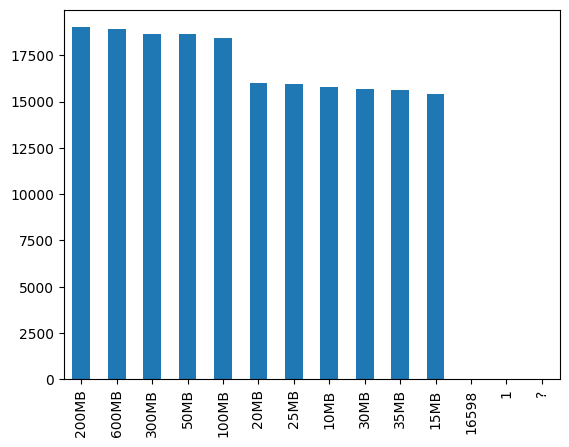

In [ ]:
# Reviso mi variable vel_conexion
data['vel_conexion'].value_counts().plot(kind='bar')

In [ ]:
# Compruebo los valores de mi variable vel_conexion y hag olas transformaciones necesarias
adsl = data.query('conexion == "ADSL"')
adsl.groupby('vel_conexion')['conexion'].count().sort_values(ascending=False)

vel_conexion
20MB     15995
25MB     15952
10MB     15776
30MB     15708
35MB     15619
15MB     15436
300MB      164
600MB      158
50MB       145
200MB      136
100MB      127
1            1
Name: conexion, dtype: int64

In [ ]:
# Vemos que dentro de las conexiones adsl, la velocidad de conexión más repetida es la de 20 MB
data['vel_conexion'] = data['vel_conexion'].replace('1', '20MB')

In [ ]:
# Sigo comprobando los valores de mi variable vel_conexion y hag olas transformaciones necesarias
fibra = data.query('conexion == "FIBRA"')
fibra.groupby('vel_conexion')['conexion'].count().sort_values(ascending=False)

vel_conexion
200MB    18881
600MB    18763
300MB    18508
50MB     18496
100MB    18303
16598        1
?            1
Name: conexion, dtype: int64

In [ ]:
# Vemos que dentro de las conexiones fibra, la velocidad de conexión más repetida es la de 200 MB
data['vel_conexion'] = data['vel_conexion'].replace('?', '200MB')
data['vel_conexion'] = data['vel_conexion'].replace('16598', '200MB')

In [ ]:
# Faltan por rellenar unos pocos nulos en la variable conexión y en la variable vel_conexion

print(data.conexion.unique())

print(data.conexion.value_counts())

# La probabilidad de rellenar el valor con ADSL o FIBRA es prácticamente el mismo. En este caso, podríamos rellenarlo con la moda ( ADSL ) o incluso eliminar las dos líneas

data['conexion'].fillna('ADSL',inplace=True)

print(data.vel_conexion.unique())

print(data.vel_conexion.value_counts())

# En el caso de la velocidad, rellenaremos con el valor 200MB (moda). En este caso, se podría haber rellenado también de varias maneras. Normalmente en estos casos, tenemos alguna información más de negocio (velocidad más probable...)

data['vel_conexion'].fillna('200MB',inplace=True)

['FIBRA' 'ADSL' nan]
ADSL     95220
FIBRA    92956
Name: conexion, dtype: int64
['50MB' '600MB' '35MB' '200MB' '10MB' '25MB' '30MB' '100MB' '20MB' '300MB'
 '15MB' nan]
200MB    19019
600MB    18921
300MB    18672
50MB     18641
100MB    18431
20MB     15996
25MB     15952
10MB     15776
30MB     15709
35MB     15619
15MB     15436
Name: vel_conexion, dtype: int64


In [ ]:
# Compruebo si siguen quedando nulos
data.isnull().sum()

id                0
edad              0
facturacion       0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
tv                0
mes               0
duracion          0
month             0
dia               0
hora              0
hora_bin          0
dtype: int64

## 4. Transformación de variables a numéricas

In [ ]:
# Defino mis variables dummies y binarias
variables_dummies = ['conexion','tv']
variables_binarias = ['financiacion','descuentos','incidencia']

In [ ]:
# Transformo las variable dummies a categoricas
for k in variables_dummies:
    dummies = pd.get_dummies(data[k],prefix=k)
    data = pd.concat([data, dummies], axis=1)
    data.drop(k, axis=1, inplace=True)

In [ ]:
# Transformo las variables binarias a categoricas
for j in variables_binarias:
    data[j] = [1 if x == 'SI' else 0 for x in data[j]]

In [ ]:
# Quito las palabras que puta contener vel_conexion
data["vel_conexion"] = data.vel_conexion.apply(lambda x: int(re.sub("MB", "", x)))
data.vel_conexion.head()

0     50
1    600
2     35
3    200
4     10
Name: vel_conexion, dtype: int64

In [ ]:
# Creo variables nuevas para las fechas

data.month.replace(('January','February','March','April','May','June','July','August','September','October','November','December'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)

data.dia.replace(('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'),
                      (1,2,3,4,5,6,7),inplace=True)

data.hora_bin.replace(('Madrugada','Mañana','Tarde','Noche'),
                      (1,2,3,4),inplace=True)

In [ ]:
# Obtenengo la comunidad autónoma de cada provincia
url = "https://es.wikipedia.org/wiki/Provincia_(Espa%C3%B1a)"
html = requests.get(url).content
df_list = pd.read_html(html)
ccaa = df_list[1]
ccaa = ccaa[["Comunidad autónoma", "Provincia"]]
ccaa.columns =ccaa.columns.str.lower()
ccaa = ccaa.rename(columns = {'comunidad autónoma': 'com_aut'})
ccaa.provincia.replace(('Baleares'),('Islas Baleares'), inplace=True)

In [ ]:
# Concateno los resultados
data = pd.merge(data,ccaa,how='left',on='provincia')
data.drop('provincia', axis=1, inplace=True )

In [ ]:
# Compruebo los resultados
data.com_aut.unique()

array(['La Rioja', 'País Vasco', 'Castilla-La Mancha', 'Galicia',
       'Cataluña', 'Andalucía', 'Comunidad Valenciana',
       'Comunidad de Madrid', 'Canarias', 'Castilla y León', 'Aragón',
       'Navarra', 'Extremadura', 'Principado de Asturias',
       'Islas Baleares', 'Cantabria', 'Región de Murcia'], dtype=object)

In [ ]:
# Sustituyo cada CCAA por un numero
data.com_aut.replace(('La Rioja', 'País Vasco', 'Castilla-La Mancha', 'Galicia',
                       'Cataluña', 'Andalucía', 'Comunidad Valenciana',
                       'Comunidad de Madrid', 'Canarias', 'Castilla y León', 'Aragón',
                       'Navarra', 'Extremadura', 'Principado de Asturias',
                       'Islas Baleares', 'Cantabria', 'Región de Murcia'),
                        (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17),inplace=True)

In [ ]:
# Añado el mes de referencia y concateno
df_dic = pd.merge(data[data['mes']=='dic'], churn, on='id', how='left')

In [ ]:
# Elimino la columna mes y ordeno por ID
df_dic.drop('mes', axis=1, inplace=True)
df_dic.set_index('id', inplace=True)

## 5. Muestreo de datos y partición training - test

In [ ]:
# Realizo mi partición training test con un split 80/20
X_train, X_test, y_train, y_test = train_test_split (df_dic.drop('churn', axis=1),
                                                     df_dic.churn,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = df_dic.churn)

## 6. Construcción del modelo analítico de clasificación

In [ ]:
# Defino mi función para evalular las métricas de cada modeno a través de la curva ROC
def saca_metricas(y_real, y_pred):
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    print('- AUC: {roc_auc}')
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

### 6.1. Decision Tree

- AUC: {roc_auc}


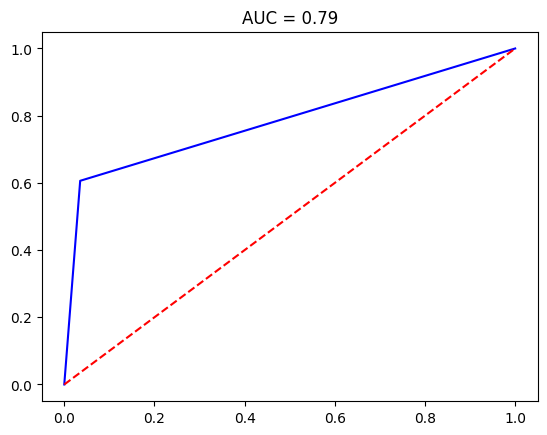

In [ ]:
# Modelo y predicciones:
tree_mod = DecisionTreeClassifier(criterion="gini").fit(X_train, y_train)
tree_pred = tree_mod.predict(X_test)

# Métricas:
saca_metricas(y_test, tree_pred)

### 6.2. Random Forest

- AUC: {roc_auc}


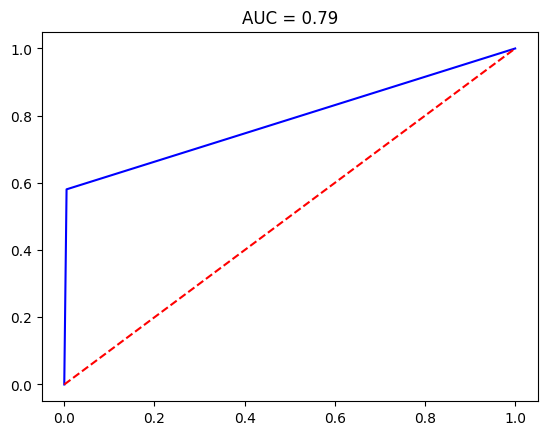

In [ ]:
# Modelo y predicciones:
classifier2 = RandomForestClassifier().fit(X_train, y_train)
pred2 = classifier2.predict(X_test)

# Métricas:
saca_metricas(y_test, pred2)

### 6.3. Linear SVC

- AUC: {roc_auc}


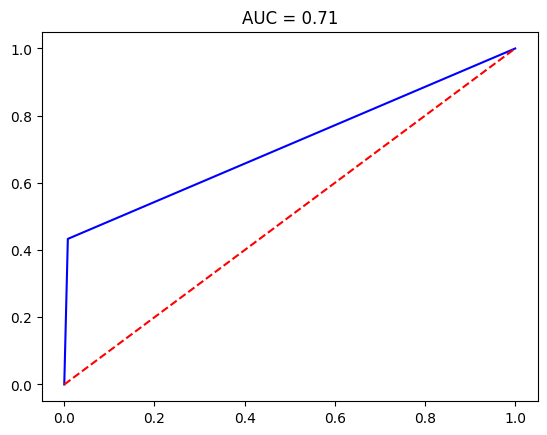

In [ ]:
# Modelo y predicciones:
classifier3 = LinearSVC(penalty='l1', dual= False).fit(X_train, y_train)
pred3 = classifier3.predict(X_test)

# Métricas:
saca_metricas(y_test, pred3)

### 6.4. Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- AUC: {roc_auc}


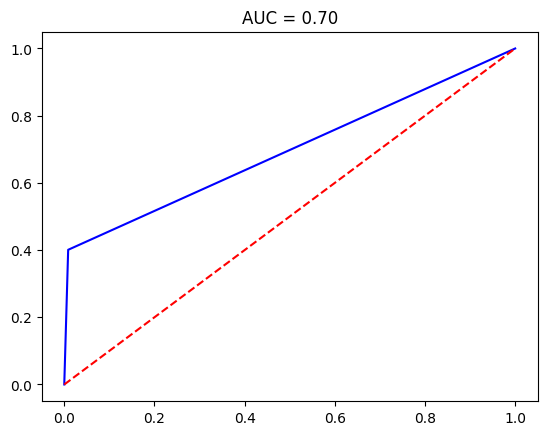

In [ ]:
# Modelo y predicciones:
classifier4 = LogisticRegression(max_iter=10000).fit(X_train, y_train)
pred4 = classifier4.predict(X_test)

# Métricas:
saca_metricas(y_test, pred4)

### Validación cruzada

In [ ]:
# Validación cruzada del modelo Random Forest
cv = cross_val_score(
    classifier2,
    X_train,
    y_train,
    scoring = "roc_auc",
    cv = 5
)
print(cv)
print("CV ROC:", cv.mean(), np.std(cv))

[0.96460512 0.96253626 0.96243315 0.96169717 0.96356906]
CV ROC: 0.9629681536902364 0.0010128095815721606


### Analizo la importancia de mis variables

In [ ]:
imp = {}
for i in range(len(X_train.columns)):
    imp[X_train.columns[i]] = [classifier2.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
edad,0.165778
num_dt,0.150760
incidencia,0.098585
descuentos,0.060144
vel_conexion,0.056895
facturacion,0.044610
seg_llamad_ent,0.042801
duracion,0.042769
mb_datos,0.041527
seg_llamad_sal,0.041461


## Predicción final

In [ ]:
# Uso mi dataset de enero
df_enero = data[data['mes']=='en']
df_enero.drop('mes', axis=1, inplace=True)
df_enero.set_index('id', inplace=True)

<ipython-input-55-d66f6d398f1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enero.drop('mes', axis=1, inplace=True)


In [ ]:
df_enero

,edad,facturacion,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,...,month,dia,hora,hora_bin,conexion_ADSL,conexion_FIBRA,tv_tv-familiar,tv_tv-futbol,tv_tv-total,com_aut
id,,,,,,,,,,,,,,,,,,,,,
1,63,216.028109,5,0.0,0,95,19,6525,7634,18520,...,11,5,8,2,0,1,0,1,0,1
2,84,255.830842,3,0.0,0,44,36,14471,14541,8016,...,8,2,3,1,0,1,0,1,0,2
3,66,135.768153,4,0.0,0,94,27,1428,5248,7106,...,12,4,13,3,1,0,0,1,0,3
4,69,255.658527,4,0.0,0,186,20,20083,7372,5052,...,8,6,10,2,0,1,1,0,0,4
6,51,99.348645,4,0.0,0,37,32,19078,5009,8686,...,11,2,11,2,0,1,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,36,215.890326,3,0.0,0,217,96,9059,7735,8823,...,4,2,13,3,1,0,0,1,0,3
99997,68,285.890750,5,0.0,0,168,99,9303,4798,3996,...,8,5,23,4,0,1,0,1,0,14
99998,20,383.167610,4,0.0,0,188,71,19018,1237,16720,...,3,3,20,4,1,0,0,1,0,2


In [ ]:
# Aplico mi modelo elegido que en este caso será Random Forest
modelo_proba = classifier2.predict_proba(df_enero)[:,1]
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=df_enero.index))
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [ ]:
# Compruebo las probabilidades de cada usuario de irse
modelo_proba

,probabilidad
id,
59623,0.97
46825,0.96
86266,0.96
35890,0.95
18774,0.94
...,...
20859,0.00
54906,0.00
54907,0.00
